In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [2]:
class Portfolio:
    def __init__(self):
        self.holdings = {}
    
    def update(self, holding, units):
        self.holdings.update({holding: units})
    
    def units(self, holding) -> int:
        return self.holdings.get(holding, 0)


In [3]:
data_dir = 'data/2024-08-19/'
funds = ['fssa-asia-focus', 'hl-select', 'lg-european', 'lg-international', 'manglg-japan', 'rathbone-global' ]

In [4]:
# Read funds CSVs
fund_dfs = {}

for filename in funds:
    df = pd.read_csv(filepath_or_buffer=f'{data_dir}/{filename}.csv', parse_dates=True, usecols=['Date', 'Adj Close'])
    df['Identifier'] = filename
    fund_dfs[filename] = df.bfill()

# Align Adjusted Close time series by date in pivot table with funds as columns
pivoted = pd.concat(objs=[fund_dfs[k] for k in fund_dfs.keys()]).pivot(index='Date', columns='Identifier', values='Adj Close').bfill()
display(pivoted.head())

Identifier,fssa-asia-focus,hl-select,lg-european,lg-international,manglg-japan,rathbone-global
Date,,,,,,
2023-08-21,208.034393,144.446289,336.710510,163.272934,226.768631,349.966614
2023-08-22,208.354324,144.586288,337.610291,163.972809,229.468246,350.676575
2023-08-23,211.693756,145.816269,338.410065,165.072632,233.967621,353.116486
2023-08-24,213.173508,147.226227,339.609772,166.872330,233.567688,355.676392
2023-08-25,212.003693,146.686234,338.410065,165.472580,232.567825,353.486481


<Figure size 1600x1600 with 0 Axes>

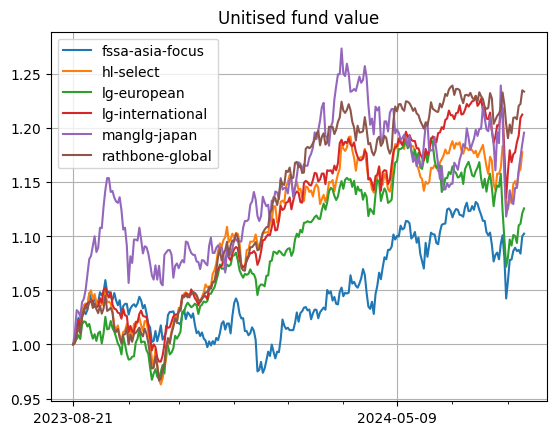

In [5]:
# Display relative price evolution of each fund
plt.figure(figsize=(16, 16))
fig, ax = plt.subplots()
ax.set_title('Unitised fund value')
ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.grid(True)

for f in pivoted.columns:
    c = pivoted[f]
    ax.plot(pivoted.index, c / c.iloc[0], label=f)

plt.legend()
plt.show()

<Figure size 1600x1600 with 0 Axes>

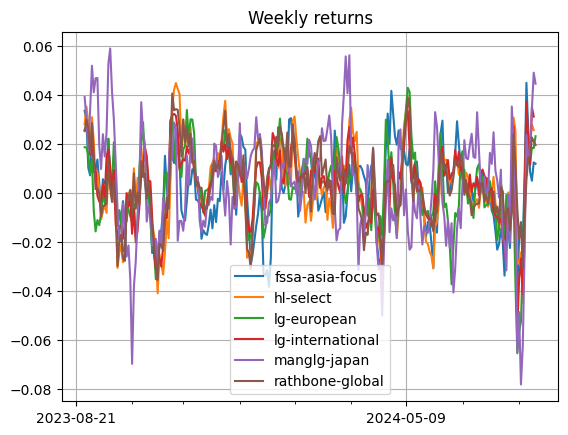

<Figure size 1600x1600 with 0 Axes>

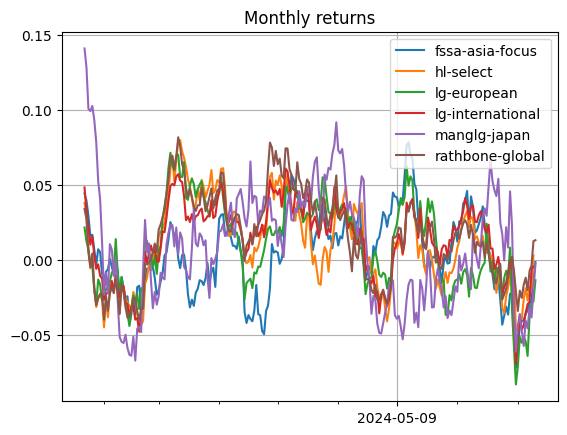

<Figure size 1600x1600 with 0 Axes>

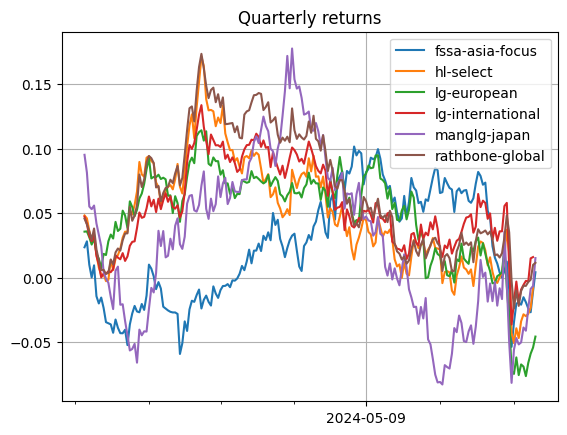

<Figure size 1600x1600 with 0 Axes>

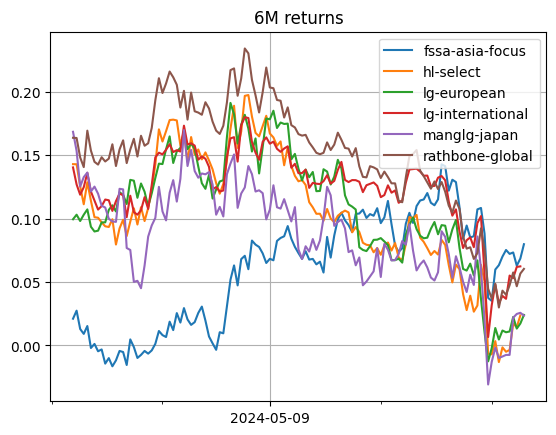

In [6]:
def plot_fund_returns(title, periods):
    plt.figure(figsize=(16, 16))
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(dates.MonthLocator())
    ax.grid(True)

    rets = pivoted.pct_change(fill_method=None, periods=periods)
    for f in pivoted.columns:
        c = rets[f]
        ax.plot(rets.index, c, label=f)

    plt.legend()
    plt.show()

plot_fund_returns("Weekly returns", 5)
plot_fund_returns("Monthly returns", 21)
plot_fund_returns("Quarterly returns", 63)
plot_fund_returns("6M returns", 126)

,0,Return 1M,Return 3M,Return 6M
Date,,,,
2024-08-13,4757.442054,-0.033224,-0.024007,0.033524
2024-08-14,4802.774077,-0.021717,-0.019629,0.045354
2024-08-15,4820.760903,-0.017770,-0.013531,0.040303
2024-08-16,4870.212553,-0.004330,-0.004389,0.046199
2024-08-19,NaN,NaN,NaN,NaN


<Figure size 1600x1600 with 0 Axes>

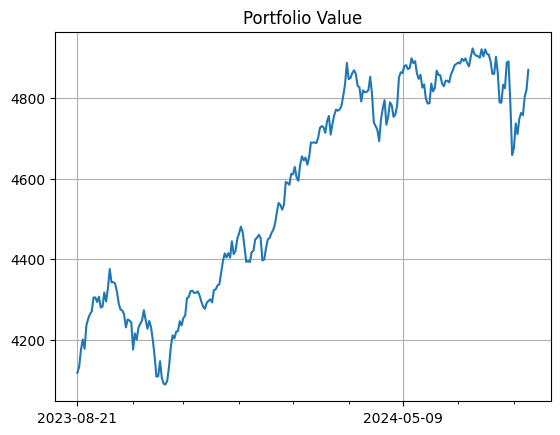

In [7]:
p = Portfolio()
p.update('fssa-asia-focus', 333.208)
p.update('lg-european', 138.476)
p.update('lg-international', 307.269)
p.update('manglg-japan', 293.275)
p.update('hl-select', 296.755)
p.update('rathbone-global', 389.39)


# Display overall portfolio value
pf_values = np.array([p.units(x) for x in pivoted.columns])
units = pd.DataFrame(data=pf_values, index=pivoted.columns)
pf = pivoted @ units / 100
pf['Return 1M'] = pf[0].pct_change(fill_method=None, periods=21)
pf['Return 3M'] = pf[0].pct_change(fill_method=None, periods=63)
pf['Return 6M'] = pf[0].pct_change(fill_method=None, periods=126)
display(pf.tail())

plt.figure(figsize=(16, 16))
fig, ax = plt.subplots()
ax.set_title('Portfolio Value')
ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.grid(True)
ax.plot(pf.index, pf[0], label='Portfolio Value')
plt.show()

<Figure size 1600x1600 with 0 Axes>

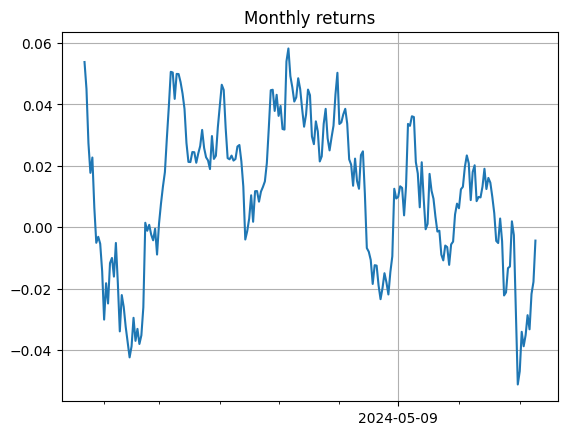

<Figure size 1600x1600 with 0 Axes>

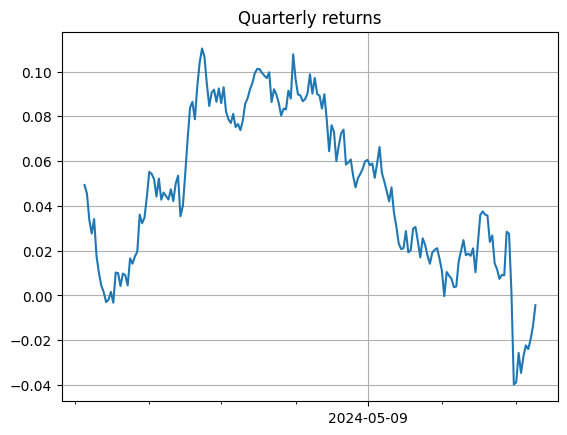

<Figure size 1600x1600 with 0 Axes>

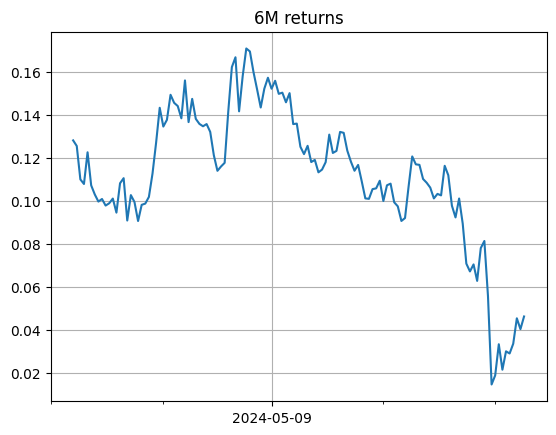

In [8]:
def plot_portfolio_returns(title, label):
    plt.figure(figsize=(16, 16))
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(dates.MonthLocator())
    ax.grid(True)
    ax.plot(pf.index, pf[label], label=label)
    plt.show()

plot_portfolio_returns("Monthly returns", "Return 1M")
plot_portfolio_returns("Quarterly returns", "Return 3M")
plot_portfolio_returns("6M returns", "Return 6M")

<Figure size 1200x1200 with 0 Axes>

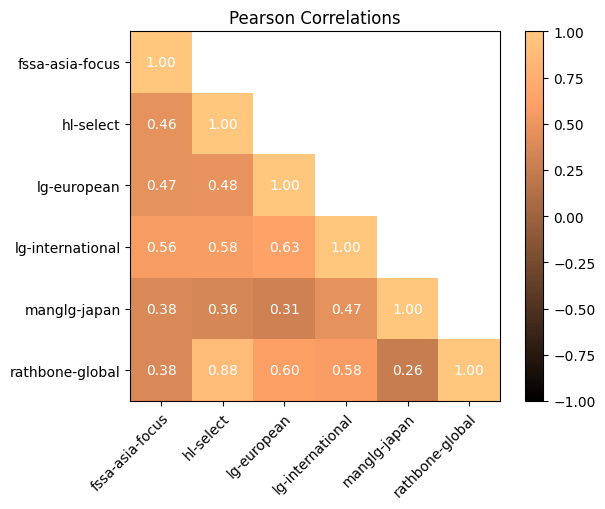

<Figure size 1200x1200 with 0 Axes>

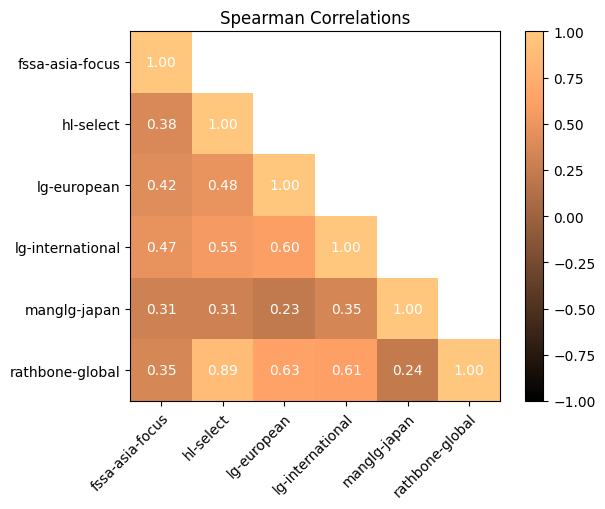

<Figure size 1200x1200 with 0 Axes>

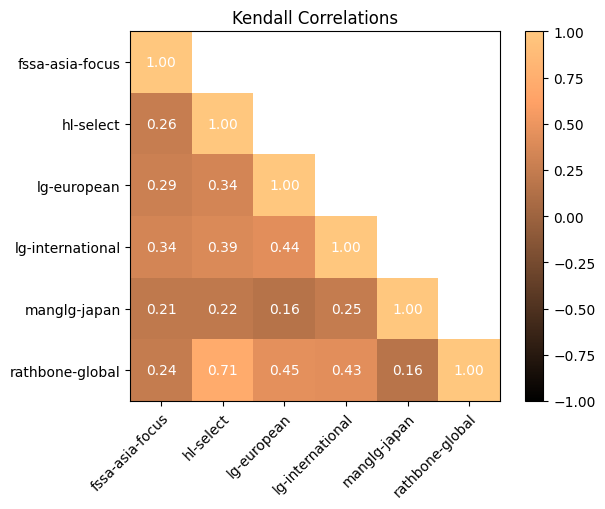

In [9]:
# Calculate and plot pearson, spearman, and kendall correlation heatmaps
def plot_correlations(m):
    assert m == 'pearson' or m == 'spearman' or m == 'kendall'
    c = pivoted.pct_change(fill_method=None).corr(method=m)
    plt.figure(figsize = (12,12))
    fig, ax = plt.subplots()
    data = c.to_numpy()
    mask = np.tri(data.shape[0], data.shape[1], k=-1).T
    data = np.ma.array(data, mask=mask)
    labels = c.columns
    a = plt.imshow(data, cmap = 'copper', interpolation = 'nearest', vmin=-1, vmax=1)
    fig.colorbar(a)

    ax.set_xticks(range(len(c)), labels=c.columns, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(c)), labels=c.columns)
    ax.set_title(f'{m.capitalize()} Correlations')

    for i in range(len(labels)):
        for j in range(i+1):
            ax.text(j, i, f'{data[i, j]:.2f}', ha='center', va='center', color='w')

    plt.show()

plot_correlations('pearson')
plot_correlations('spearman')
plot_correlations('kendall')
